<a href="https://colab.research.google.com/github/realdarter/MovieChatBot-RNN/blob/main/NLP_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import math
import numpy as np
import pandas as pd
from sklearn import model_selection
import re
print(tf.__version__)

2.15.0


In [ ]:
from google.colab import files

# Upload your kaggle.json file
#uploaded = files.upload()

#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hijest/cleaned-data-for-the-chatbot-collected-from-movies

# Unzip the dataset
!unzip cleaned-data-for-the-chatbot-collected-from-movies.zip

Dataset URL: https://www.kaggle.com/datasets/hijest/cleaned-data-for-the-chatbot-collected-from-movies
License(s): copyright-authors
cleaned-data-for-the-chatbot-collected-from-movies.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cleaned-data-for-the-chatbot-collected-from-movies.zip
replace dialogs_expanded.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace input3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model_att29iter_expanded.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model_att29iter_expanded.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace target3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data_df = pd.read_csv("dialogs_expanded.csv", index_col=False)
#data_df = data_df.sample(frac=0.5) #fractional trained here
print("Number of elements in features:", data_df.count())

Number of elements in features: Unnamed: 0         139409
question           139409
answer             139409
question_as_int    139409
answer_as_int      139409
question_len       139409
answer_len         139409
dtype: int64


In [ ]:
data_df.drop(['Unnamed: 0','question_as_int','answer_as_int','question_len','answer_len'], axis=1, inplace=True)

In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('\n', '', text)
  text = re.sub(r'[^\w]',' ',text)
  text = re.sub('\w*\d\w*', '', text)
  #text = re.sub(r'\s+', ' ', text)  # Remove consecutive spaces
  return text

data_df.question = data_df.question.map(clean_text)
data_df.answer = data_df.answer.map(clean_text)

In [ ]:
def add_start_end(text):
  text = f'<start> {text} <end>'
  return text

data_df.question = data_df.question.map(add_start_end)
data_df.answer = data_df.answer.map(add_start_end)

In [ ]:
#data_df

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', oov_token='<OOV>'
  )
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

In [ ]:
question_sequence, question_tokenizer = tokenize(data_df.question)
answer_sequence, answer_tokenizer = tokenize(data_df.answer)

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(question_sequence,
                answer_sequence, test_size = 0.1, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((125468, 29), (13941, 29), (125468, 32), (13941, 32))

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print('%d -> %s' % (t, lang.index_word[t]))

convert(question_tokenizer, x_train[0])
convert(answer_tokenizer, y_train[0])

2---> <start>
80---> yeah
13---> that
8---> s
11002---> blush
36---> on
32---> my
301---> wife
3384---> uses
9---> it
3---> <end>
2---> <start>
204---> ask
5535---> travis
22---> he
7---> s
6---> the
1765---> ladies
104---> man
3---> <end>


In [ ]:
vocab_inp_size = len(question_tokenizer.word_index)+1
vocab_tar_size =  len(answer_tokenizer.word_index)+1
embedding_dim = 256
units = 1024
batch_size=32

In [ ]:
def create_dataset(x, y, batch_size=32):
  data = tf.data.Dataset.from_tensor_slices((x, y))

  data = data.shuffle(1028)
  data = data.batch(batch_size, drop_remainder=True)

  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

train_dataset = create_dataset(x_train, y_train)
test_dataset = create_dataset(x_test, y_test)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size):
      super(Encoder, self).__init__()

      self.batch_size = batch_size
      self.encoder_units = encoder_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
      self.gru = tf.keras.layers.GRU(self.encoder_units,
                                           return_sequences=True,
                                           return_state=True,
                                           recurrent_initializer = 'glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.encoder_units))

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size):
      super(Decoder, self).__init__()

      self.batch_size = batch_size
      self.decoder_units = decoder_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
      self.gru = tf.keras.layers.GRU(self.decoder_units,
                                           return_sequences=True,
                                           return_state=True,
                                           recurrent_initializer = 'glorot_uniform')

      self.fc = tf.keras.layers.Dense(vocab_size)


  def call(self, x, hidden):
    x = self.embedding(x)
    output, hidden = self.gru(x, initial_state = hidden)
    output = tf.reshape(output, (-1, output.shape[2]))
    x =  tf.nn.softmax(self.fc(output))
    return x, hidden

In [ ]:
# vocab_inp_size = len(eng_tokenizer.word_index)+1
# vocab_tar_size =  len(spn_tokenizer.word_index)+1
# embedding_dim = 256
# units = 1024
# batch_size=32

encoder = Encoder(vocab_inp_size, embedding_dim, units, batch_size)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(q, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (32, 29, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, batch_size)

sample_decoder_output, _ = decoder(tf.random.uniform((batch_size, 1)), sample_hidden)

print ('Decoder output shape: (batch size, vocab_size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch size, vocab_size) (32, 27849)


In [ ]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)


In [ ]:
# the training metrics
train_loss = tf.metrics.Mean(name='train loss')
# training loss
test_loss =tf.metrics.Mean(name='test loss')

accuracy = tf.keras.metrics.Accuracy()

In [ ]:
# create the training step
# using the tf.function decorator to speed up the training process by converting the training function to a TensorFlow graph
@tf.function
def train_step(inputs, target, encoder_hidden_state):
    total_loss = 0

    with tf.GradientTape() as tape:
        encoder_output, encoder_hidden_state = encoder(inputs, encoder_hidden_state)
        decoder_hidden_state = encoder_hidden_state
        decoder_input = tf.expand_dims([answer_tokenizer.word_index['<start>']] * inputs.shape[0], 1)

        for timestep in range(1, target.shape[1]):
            predictions, decoder_hidden_state = decoder(decoder_input, decoder_hidden_state)
            total_loss += loss_function(target[:, timestep], predictions)
            decoder_input = tf.expand_dims(target[:, timestep], 1)

    batch_loss = (total_loss / int(target.shape[1]))

    all_trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(total_loss, all_trainable_variables)
    optimizer.apply_gradients(zip(gradients, all_trainable_variables))
    train_loss(batch_loss)

    return batch_loss

In [ ]:
@tf.function
def test_step(inputs, target, enc_hidden_state):
    loss = 0

    enc_output, enc_hidden_state = encoder(inputs, enc_hidden_state)
    dec_hidden_state = enc_hidden_state
    dec_input = tf.expand_dims([answer_tokenizer.word_index['<start>']] * inputs.shape[0], 1)

    for time_step in range(1, target.shape[1]):
        predictions, dec_hidden_state = decoder(dec_input, dec_hidden_state)
        loss += loss_function(target[:, time_step], predictions)
        dec_input = tf.expand_dims(target[:, time_step], 1)

    batch_loss = (loss / int(target.shape[1]))
    test_loss(batch_loss)
    return batch_loss


In [ ]:
# Initialize lists to store metrics
train_losses = []
test_losses = []


In [ ]:
EPOCHS = 4
old_test_loss = math.inf # extremly high number here.

for epoch in range(EPOCHS):
    train_loss.reset_states()
    test_loss.reset_states()

    enc_hidden = encoder.initialize_hidden_state()
    steps_per_epoch = answer_sequence.shape[0] // batch_size
    bar = tf.keras.utils.Progbar(target=steps_per_epoch)

    count = 0

    for (batch, (inputs, target)) in enumerate(train_dataset):
        count += 1
        batch_loss = train_step(inputs, target, enc_hidden)
        bar.update(count)

    for (batch, (inputs, target)) in enumerate(test_dataset):
        count += 1
        batch_loss = test_step(inputs, target, enc_hidden)
        bar.update(count)

    if old_test_loss > test_loss.result():
        old_test_loss = test_loss.result()
        encoder.save(filepath='/content/models/encoder')
        decoder.save(filepath='/content/models/decoder')
        print('Model is saved')

    train_losses.append(train_loss.result())
    test_losses.append(test_loss.result())

    print('#' * 50)
    print(f'Epoch #{epoch + 1}')
    print(f'Training Loss {train_loss.result()}')
    print(f'Testing Loss {test_loss.result()}')

    print('#' * 50)


4355/4356 [============================>.] - ETA: 0sModel is saved
##################################################
Epoch #1
Training Loss 1.42347252368927
Testing Loss 1.2973767518997192
##################################################
4355/4356 [============================>.] - ETA: 0sModel is saved
##################################################
Epoch #2
Training Loss 1.2022850513458252
Testing Loss 1.286497712135315
##################################################
4355/4356 [============================>.] - ETA: 0s##################################################
Epoch #3
Training Loss 1.0612324476242065
Testing Loss 1.3273940086364746
##################################################
4355/4356 [============================>.] - ETA: 0s##################################################
Epoch #4
Training Loss 0.9226781725883484
Testing Loss 1.3844581842422485
##################################################
4355/4356 [============================>.] - ETA: 0s#########

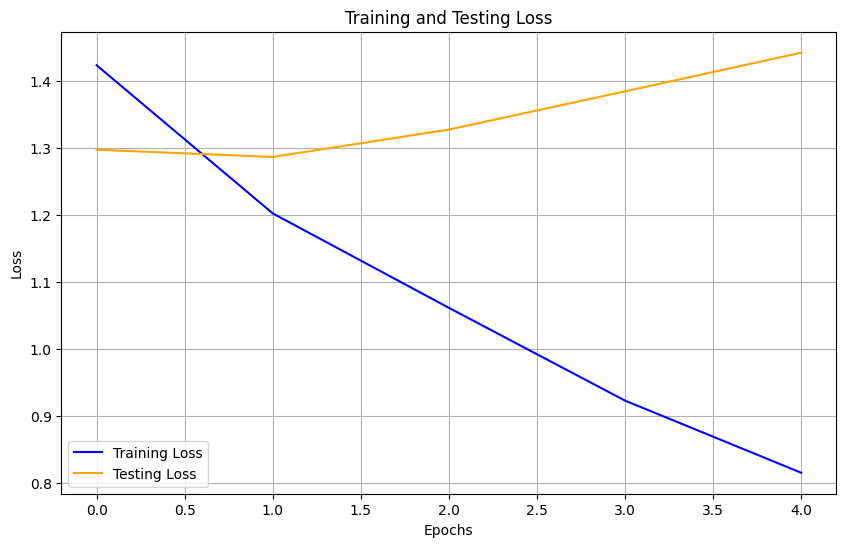

In [ ]:
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='orange')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def generate_response(sentence):
  cleaned_sentence = clean_text(sentence)
  preprocessed_sentence = add_start_end(cleaned_sentence)
  inputs = question_tokenizer.texts_to_sequences([preprocessed_sentence])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=29, padding='post')

  initial_hidden_state = [tf.zeros((1, units))]
  encoder_output, encoder_hidden_state = encoder(inputs, initial_hidden_state)
  decoder_hidden_state = encoder_hidden_state
  decoder_input = tf.expand_dims([answer_tokenizer.word_index['<start>']], 0)
  result = ''

  for _ in range(32):
    predictions, decoder_hidden_state = decoder(decoder_input, decoder_hidden_state)
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += answer_tokenizer.index_word[predicted_id] + ' '
    if answer_tokenizer.index_word[predicted_id] == '<end>':
      result = result.replace('<start> ', '')
      result = result.replace(' <end> ','')
      cleaned_sentence = cleaned_sentence.replace('<start> ', '')
      cleaned_sentence = cleaned_sentence.replace(' <end>', '')
      return  cleaned_sentence, result

    decoder_input = tf.expand_dims([predicted_id], 0)

  result = result.replace('<start> ', '')
  result = result.replace('<end>','')
  cleaned_sentence = cleaned_sentence.replace('<start> ', '')
  cleaned_sentence = cleaned_sentence.replace('<end>', '')

  return cleaned_sentence, result


In [ ]:
generate_response("how are you today")

('how are you today', 'tolerable i m fine')

In [ ]:
generate_response('what is the weather outside')

('what is the weather outside', 'the american')

In [ ]:
generate_response('can you run')


('can you run', 'i can t imagine')

In [ ]:
generate_response(' how old ')

(' how old ', 'four or three')

In [ ]:
generate_response('can you play')

('can you play', 'i m not sure')

In [ ]:
generate_response('where you goin')

('where you goin', 'i don t know')

In [ ]:
while True:
    user_input = input("You: ")
    if user_input.lower() == 'q':
        print("Goodbye!")
        break
    else:
        _, response = generate_response(user_input)
        print("Bot:", response)